In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import numpy as np

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
from lib.dataset import unpack_drawings
from lib.dataset import transform_strokes, reconstruct_strokes
from lib.dataset import get_n_points, cut_strokes
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import PADDING_VALUE
from lib.plot import get_canvas, plot, get_animation
from lib.model import LSTM, evaluate, generate, masked_mse_loss, train

# Load and show dataset

In [7]:
dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = list(dataset)

In [8]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

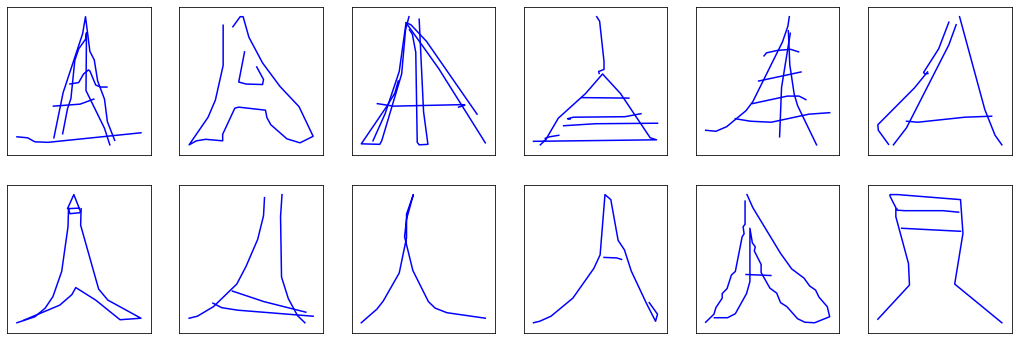

In [9]:
fig, axarr = get_canvas(2, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

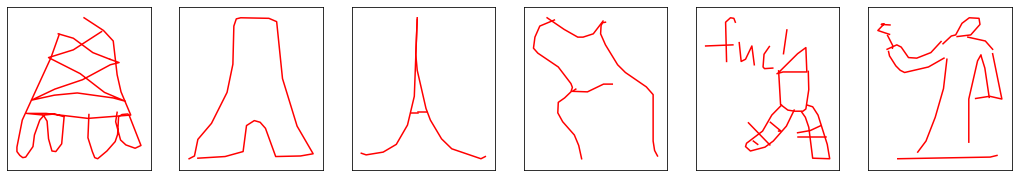

In [10]:
fig, axarr = get_canvas(1, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [11]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [12]:
HTML(anim.to_html5_video())

In [13]:
anim.save('effeil.gif', dpi=80, writer='imagemagick')

# Create pytorch dataset

In [14]:
drawings = [drawing for drawing in good_drawings if 10 <= get_n_points(drawing) <= 50]
ds = get_dataset(drawings)

torch.Size([123453, 48, 5]) torch.Size([123453, 48, 5]) tensor([48, 48, 48,  ...,  8,  8,  8], dtype=torch.int32)


In [15]:
ds = get_dataset(drawings)

torch.Size([123453, 48, 5]) torch.Size([123453, 48, 5]) tensor([48, 48, 48,  ...,  8,  8,  8], dtype=torch.int32)


In [16]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.005)

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(487, 149)

In [17]:
# Debug
train_batches = get_batches(train_ds, batch_size=3)
data_batch, labels_batch, lens_batch = next(iter(train_batches))
data_batch.shape, labels_batch.shape, lens_batch.shape

(torch.Size([48, 3, 5]), torch.Size([48, 3, 5]), torch.Size([3]))

# Train

In [18]:
batch_size = 1024
n_input_dim = 5
n_hidden = 128
n_layers = 1
dropout = 0.3 if n_layers > 1 else 0

lstm = LSTM(batch_size, n_input_dim, n_hidden, n_layers, dropout)
if torch.cuda.is_available():
    lstm = lstm.cuda()

criterion = masked_mse_loss
optimizer = Adam(lstm.parameters(), 1e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)

In [19]:
train(lstm, scheduler, criterion, train_ds, val_ds, batch_size, epochs=500, epochs_between_evals=10)

epoch:   1   train_loss: 947.79   val_loss: 978.72
epoch:  10   train_loss: 943.34   val_loss: 974.57


KeyboardInterrupt: 

In [79]:
torch.save(lstm.state_dict(), 'model1.pth')

In [80]:
train(lstm, scheduler, criterion, train_ds, val_ds, batch_size, epochs=500, epochs_between_evals=10)

epoch:   1   train_loss: 2396.01   val_loss: 2376.32
epoch:  10   train_loss: 2395.34   val_loss: 2375.87
epoch:  20   train_loss: 2394.59   val_loss: 2375.37
epoch:  30   train_loss: 2393.84   val_loss: 2374.88
epoch:  40   train_loss: 2393.10   val_loss: 2374.40
epoch:  50   train_loss: 2392.36   val_loss: 2373.89
epoch:  60   train_loss: 2391.62   val_loss: 2373.38
epoch:  70   train_loss: 2390.88   val_loss: 2372.88
epoch:  80   train_loss: 2390.16   val_loss: 2372.38
epoch:  90   train_loss: 2389.44   val_loss: 2371.88
epoch: 100   train_loss: 2388.72   val_loss: 2371.38
epoch: 110   train_loss: 2388.01   val_loss: 2370.88
epoch: 120   train_loss: 2387.31   val_loss: 2370.39
epoch: 130   train_loss: 2386.62   val_loss: 2369.90
epoch: 140   train_loss: 2385.93   val_loss: 2369.44
epoch: 150   train_loss: 2385.26   val_loss: 2368.98
epoch: 160   train_loss: 2384.59   val_loss: 2368.52
epoch: 170   train_loss: 2383.92   val_loss: 2368.07
epoch: 180   train_loss: 2383.25   val_loss: 2

In [81]:
torch.save(lstm.state_dict(), 'model2.pth')

In [82]:
train(lstm, scheduler, criterion, train_ds, val_ds, batch_size, epochs=500, epochs_between_evals=10)

epoch:   1   train_loss: 2363.92   val_loss: 2355.56
epoch:  10   train_loss: 2363.39   val_loss: 2355.24
epoch:  20   train_loss: 2362.85   val_loss: 2354.95
epoch:  30   train_loss: 2362.31   val_loss: 2354.65
epoch:  40   train_loss: 2361.77   val_loss: 2354.35
epoch:  50   train_loss: 2361.23   val_loss: 2354.05
epoch:  60   train_loss: 2360.69   val_loss: 2353.76
epoch:  70   train_loss: 2360.16   val_loss: 2353.47
epoch:  80   train_loss: 2359.64   val_loss: 2353.18
epoch:  90   train_loss: 2359.12   val_loss: 2352.90
epoch: 100   train_loss: 2358.60   val_loss: 2352.62
epoch: 110   train_loss: 2358.09   val_loss: 2352.34
epoch: 120   train_loss: 2357.59   val_loss: 2352.07
epoch: 130   train_loss: 2357.09   val_loss: 2351.80
epoch: 140   train_loss: 2356.59   val_loss: 2351.54
epoch: 150   train_loss: 2356.10   val_loss: 2351.28
epoch: 160   train_loss: 2355.61   val_loss: 2351.02
epoch: 170   train_loss: 2355.13   val_loss: 2350.77
epoch: 180   train_loss: 2354.65   val_loss: 2

In [83]:
torch.save(lstm.state_dict(), 'model3.pth')

# Predict

In [84]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
lstm.load_state_dict(torch.load('model3.pth', map_location=map_location))

In [52]:
n_initial_points = 3

idx = np.random.choice(len(val_ds))
flat_strokes = val_ds[idx][0].tolist()
start_of_stroke = flat_strokes[:n_initial_points]

In [70]:
pred_flat_strokes = generate(lstm, start_of_stroke, 20)
pred_flat_strokes

[[-15, -8, 1, 0, 0],
 [-13, -14, 1, 0, 0],
 [-36, -16, 1, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [63]:
%%capture

from lib.plot import get_animation

strokes = reconstruct_strokes(flat_strokes)
anim = get_animation(strokes)

cut_drawing = cut_strokes(strokes, n_initial_points)
cut_anim = get_animation(cut_drawing)

pred_strokes = reconstruct_strokes(pred_flat_strokes)
pred_anim = get_animation(pred_strokes)

In [67]:
# Ground truth drawing
HTML(anim.to_html5_video())

In [68]:
# Ground truth drawing
HTML(cut_anim.to_html5_video())

In [69]:
# Generated drawing
HTML(pred_anim.to_html5_video())